# 异或操作
使用sigmoid后急剧提升！！！

In [38]:
import torch
from torch import nn
data = [[0,0],[0,1],[1,0],[1,1]]
data = torch.tensor(data).float()
labels = [[0],[1],[1],[0]]
labels = torch.tensor(labels).float()

In [147]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer1 = torch.nn.Linear(2,20)
        self.layer2 = torch.nn.Linear(20,1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
#         x = torch.softmax(x,dim=1)
#         x = torch.max(x,dim=1).values.reshape(4,1)
        return x

In [148]:
net = Net()
for param in net.parameters():
    param.data.normal_()

In [149]:
net(data)

tensor([[0.1557],
        [0.0708],
        [0.0575],
        [0.0130]], grad_fn=<SigmoidBackward>)

In [152]:
num_epoches = 100
lr=0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr)
for i in range(num_epoches):
    # 前向传播
    out = net(data)
    loss = criterion(out, labels)
    # 反向传播
    optimizer.zero_grad()  # 清空所有被优化过的Variable的梯度
    loss.backward()        
    print(loss.item())
    optimizer.step()       # 进行单次优化 (参数更新)

1.7001861124299467e-05
1.7049747839337215e-05
1.6907095414353535e-05
1.6756537661422044e-05
1.6593376130913384e-05
1.646103737584781e-05
1.6355867046513595e-05
1.6232117559411563e-05
1.6099027561722323e-05
1.5963525584083982e-05
1.5831305063329637e-05
1.5726125639048405e-05
1.561258250148967e-05
1.5493478713324293e-05
1.5370742403320037e-05
1.5245163012878038e-05
1.5121780961635523e-05
1.5015305507404264e-05
1.490757040301105e-05
1.4791507965128403e-05
1.4676716091344133e-05
1.4562268916051835e-05
1.4448424735746812e-05
1.4346393072628416e-05
1.4236546121537685e-05
1.4125125744612888e-05
1.4017284229339566e-05
1.3918928743805736e-05
1.381551737722475e-05
1.3713181033381261e-05
1.3612419934361242e-05
1.3509983546100557e-05
1.341129063803237e-05
1.3315360774868168e-05
1.3216711522545666e-05
1.3124474207870662e-05
1.3032556125835981e-05
1.2936830898979679e-05
1.2842766409448814e-05
1.2752379006997216e-05
1.2660563697863836e-05
1.256611903954763e-05
1.2481745216064155e-05
1.239707307831849

In [153]:
net(data)

tensor([[0.0029],
        [0.9971],
        [0.9971],
        [0.0029]], grad_fn=<SigmoidBackward>)

# MNIST

## 读取数据

In [18]:
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 读取数据集

我们可以通过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。

In [19]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
# 把一个取值范围是[0,255]的PIL.Image或者shape为(H,W,C)的numpy.ndarray
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans,
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                               transform=trans, download=True)

Fashion-MNIST 由 10 个类别的图像组成，每个类别由训练数据集中的 6000 张图像和测试数据集中的 1000 张图像组成。*测试数据集*（test dataset）不会用于训练，只用于评估模型性能。训练集和测试集分别包含 60000 和 10000 张图像。


In [20]:
len(mnist_train[0]), len(mnist_test[0])

(2, 2)

每个输入图像的高度和宽度均为 28 像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，在这本书中，我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。


In [21]:
mnist_train[0][0].shape  # 第一个括号是该图像的分类标签，第二个括号是每个分类的第几个图像

torch.Size([1, 28, 28])

In [22]:
mnist_train[0][1]

9

Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。


In [23]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。


In [24]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表。"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签（文本形式）。


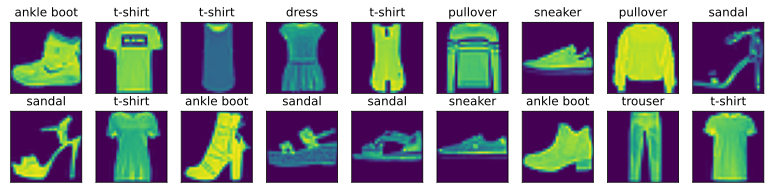

In [25]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建一个。
回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为`batch_size`。我们在训练数据迭代器中还随机打乱了所有样本。


In [26]:
batch_size = 256
import sys
def get_dataloader_workers():
       return 0 if sys.platform.startswith('win') else 4   # windows上容易引发问题。

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

让我们看一下读取训练数据所需的时间。


In [27]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.49 sec'

### 整合所有组件

现在我们定义了 `load_data_fashion_mnist` 函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。


In [28]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)  # 整合多个操作，但是这里只有一个
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定`resize`参数来测试`load_data_fashion_mnist`函数的图像大小调整功能。


In [29]:
train_iter, test_iter = load_data_fashion_mnist(32)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    print(y.size().numel())
    print(y.size())
    print(y)
    print(len(y))
    break

torch.Size([32, 1, 28, 28]) torch.float32 torch.Size([32]) torch.int64
32
torch.Size([32])
tensor([1, 8, 3, 4, 4, 2, 7, 4, 9, 2, 8, 1, 0, 1, 2, 4, 9, 1, 5, 6, 8, 2, 0, 7,
        5, 7, 2, 5, 8, 6, 4, 8])
32


In [30]:
next(iter(train_iter))[0].shape

torch.Size([32, 1, 28, 28])

In [31]:
next(iter(train_iter))[0].squeeze(1).shape

torch.Size([32, 28, 28])

## 测试代码

In [15]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  
    cmp = y_hat.type(y.dtype) == y   # 将其转为y的类型再做比较，cmp是一个布尔值列表
    return float(cmp.type(y.dtype).sum())   # 转为int64再计数

In [90]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [17]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [51]:
data = next(iter(train_iter))[0]
net(data).shape

torch.Size([32, 10])

In [41]:
torch.softmax(net(data),dim=-1).shape

torch.Size([32, 10])

In [42]:
next(iter(train_iter))[1]

tensor([4, 2, 8, 0, 9, 0, 4, 9, 2, 0, 8, 3, 3, 6, 9, 5, 1, 7, 4, 7, 5, 8, 0, 5,
        9, 1, 7, 2, 0, 5, 8, 0])

In [50]:
accuracy(torch.softmax(net(data),dim=-1),next(iter(train_iter))[1])

1.0

In [49]:
evaluate_accuracy(net, test_iter)

0.165

## 使用softmax分类

In [47]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer1 = torch.nn.Flatten()
        self.layer2 = torch.nn.Linear(784,10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
net = Net()

In [56]:
criterion = nn.CrossEntropyLoss()
loss = criterion(net(data),torch.randint(1,10,(1,32)).squeeze(0))
print(loss)
float(loss)*10

tensor(2.3583, grad_fn=<NllLossBackward>)


23.582842350006104

初始化模型及参数

In [114]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
# 初始化模型参数
for param in net.parameters():
    param.data.normal_()
num_epoches = 50
lrls=[0.1,0.05,0.01]
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.Adam(net.parameters(),lr)
# for i in range(num_epoches):
#     if(i<=10):
#         lr = lrls[0]
#     elif(10<i<40):
#         lr = lrls[1]
#     else:
#         lr = lrls[2]

In [78]:
def train_epoch(net,train_iter,criterion,optimizer):
    net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        X = X.to(device)
        y = y.to(device)
        # 前向传播
        y_hat = net(X)
        loss = criterion(y_hat, y)
        # 反向传播
        optimizer.zero_grad()  # 清空所有被优化过的Variable的梯度
        loss.backward()        
        optimizer.step()       # 进行单次优化 (参数更新)
        # 交叉熵损失默认是求平均，所以需要乘上个数
        metric.add(float(loss) * len(y), accuracy(y_hat, y),y.size().numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [71]:
# 训练一个epoch
train_epoch(net,train_iter,criterion,optimizer)

1.0757687091827393	32	32
2.1902592182159424	32	32
1.4540513753890991	32	32
1.04657781124115	32	32
2.3834986686706543	32	32
3.1187729835510254	32	32
0.4698141813278198	32	32
1.0817397832870483	32	32
2.094846487045288	32	32
3.1927645206451416	32	32
2.0719759464263916	32	32
0.96099454164505	32	32
1.3562629222869873	32	32
0.7234030961990356	32	32
0.7456473112106323	32	32
0.7798333168029785	32	32
1.3871413469314575	32	32
1.4558202028274536	32	32
0.592639148235321	32	32
1.0524591207504272	32	32
1.105465292930603	32	32
0.2827160656452179	32	32
0.49446067214012146	32	32
1.946172833442688	32	32
1.2578039169311523	32	32
0.7616022825241089	32	32
0.6941876411437988	32	32
1.3511029481887817	32	32
2.9828526973724365	32	32
0.9666816592216492	32	32
1.5957432985305786	32	32
1.9523502588272095	32	32
1.506669282913208	32	32
1.4270954132080078	32	32
1.912384271621704	32	32
3.4960439205169678	32	32
1.9843772649765015	32	32
0.8558987379074097	32	32
0.04888725280761719	32	32
1.4942843914031982	32	32
1.858896

1.0607119798660278	32	32
6.40969705581665	32	32
1.6035661697387695	32	32
2.400493621826172	32	32
1.5796949863433838	32	32
0.9834189414978027	32	32
1.6109602451324463	32	32
2.171566963195801	32	32
2.592468738555908	32	32
1.5349209308624268	32	32
0.9357582330703735	32	32
0.7906087636947632	32	32
2.018969774246216	32	32
1.5840610265731812	32	32
1.9507335424423218	32	32
1.8524330854415894	32	32
1.8821628093719482	32	32
0.942192554473877	32	32
2.178928852081299	32	32
0.6470307111740112	32	32
1.7807947397232056	32	32
2.9802567958831787	32	32
1.4020551443099976	32	32
1.8648678064346313	32	32
0.41945239901542664	32	32
1.9777541160583496	32	32
1.8095282316207886	32	32
0.07641986757516861	32	32
1.5606426000595093	32	32
0.8831133842468262	32	32
1.3823341131210327	32	32
0.4561145007610321	32	32
3.3019001483917236	32	32
0.7807196378707886	32	32
2.2887532711029053	32	32
2.8888731002807617	32	32
1.266330599784851	32	32
1.739598274230957	32	32
1.819838523864746	32	32
3.2956955432891846	32	32
2.2915475

3.526754856109619	32	32
2.1096954345703125	32	32
3.809171438217163	32	32
2.018758773803711	32	32
3.0132455825805664	32	32
1.908267855644226	32	32
0.8342849016189575	32	32
1.4609854221343994	32	32
0.8796875476837158	32	32
3.042785167694092	32	32
1.1450865268707275	32	32
5.358571529388428	32	32
1.7870219945907593	32	32
1.3339191675186157	32	32
1.6597671508789062	32	32
0.8961302042007446	32	32
2.080697774887085	32	32
0.23715072870254517	32	32
0.7624683380126953	32	32
0.6198878288269043	32	32
1.8089444637298584	32	32
0.6829270720481873	32	32
0.556484043598175	32	32
1.2057583332061768	32	32
3.6366968154907227	32	32
2.1373660564422607	32	32
1.478675127029419	32	32
3.0893774032592773	32	32
1.6112545728683472	32	32
3.1104774475097656	32	32
1.7625417709350586	32	32
0.5031200051307678	32	32
2.5805206298828125	32	32
2.474318265914917	32	32
2.503791093826294	32	32
0.2810244858264923	32	32
2.2189958095550537	32	32
2.173170328140259	32	32
1.6885721683502197	32	32
0.6501492857933044	32	32
3.667354106

2.6735475063323975	32	32
2.5359864234924316	32	32
1.607617735862732	32	32
1.236236333847046	32	32
1.577090859413147	32	32
2.7688961029052734	32	32
2.1937687397003174	32	32
2.5392003059387207	32	32
1.7976629734039307	32	32
7.2846455574035645	32	32
3.642726182937622	32	32
1.8127121925354004	32	32
0.9188880920410156	32	32
3.775543689727783	32	32
1.2609368562698364	32	32
0.20315474271774292	32	32
0.7897881269454956	32	32
1.0295218229293823	32	32
1.0611400604248047	32	32
1.0874868631362915	32	32
1.5570175647735596	32	32
0.24688301980495453	32	32
1.5617808103561401	32	32
1.9119633436203003	32	32
0.9022405743598938	32	32
0.9126198291778564	32	32
1.5702567100524902	32	32
1.67389714717865	32	32
2.495150089263916	32	32
1.3567495346069336	32	32
2.3923747539520264	32	32
2.8152616024017334	32	32
1.2704906463623047	32	32
2.1743948459625244	32	32
1.592725396156311	32	32
3.23256254196167	32	32
2.345109701156616	32	32
1.225212574005127	32	32
3.049689769744873	32	32
2.321337938308716	32	32
1.85195171833

1.6346726417541504	32	32
1.4700775146484375	32	32
2.167579412460327	32	32
0.782509982585907	32	32
0.6909798383712769	32	32
1.2885838747024536	32	32
2.178838014602661	32	32
3.4041991233825684	32	32
0.9551704525947571	32	32
0.9833862781524658	32	32
0.9489632844924927	32	32
0.438759446144104	32	32
4.439158916473389	32	32
0.5289492607116699	32	32
1.9657260179519653	32	32
0.9284939169883728	32	32
3.3392844200134277	32	32
0.7816122770309448	32	32
2.6439368724823	32	32
1.3983769416809082	32	32
1.7195171117782593	32	32
3.4148483276367188	32	32
3.210284471511841	32	32
2.9129347801208496	32	32
1.6879570484161377	32	32
0.31260013580322266	32	32
0.7355545163154602	32	32
2.1040596961975098	32	32
2.237618923187256	32	32
2.8535244464874268	32	32
3.992997646331787	32	32
3.7454962730407715	32	32
0.43861210346221924	32	32
2.9655685424804688	32	32
1.5119478702545166	32	32
0.8917638659477234	32	32
3.4207379817962646	32	32
5.596571922302246	32	32
3.749563455581665	32	32
2.2269601821899414	32	32
1.187337636

3.8680217266082764	32	32
1.9059323072433472	32	32
2.402486562728882	32	32
2.584867477416992	32	32
2.310328245162964	32	32
3.896596908569336	32	32
1.1357605457305908	32	32
0.6440487504005432	32	32
2.7656431198120117	32	32
0.6741892099380493	32	32
3.3597939014434814	32	32
2.844097137451172	32	32
4.327790260314941	32	32
0.7423312067985535	32	32
0.8431176543235779	32	32
0.15330985188484192	32	32


(1.8638339075947181, 0.81285)

In [105]:
def train(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    for param in net.parameters():
        param.data.normal_()
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'训练损失：{train_metrics[0]}，训练准确率：{train_metrics[1]}，测试准确率：{test_acc}')

In [93]:
train(net, train_iter, test_iter, criterion, 20, optimizer)

训练损失：1.8127380110969147，训练准确率：0.8239，测试准确率：0.7672
训练损失：1.8323493407261868，训练准确率：0.8231166666666667，测试准确率：0.8141
训练损失：1.7782095255432029，训练准确率：0.8227833333333333，测试准确率：0.7765
训练损失：1.808153015760084，训练准确率：0.8230166666666666，测试准确率：0.785
训练损失：1.821358500981331，训练准确率：0.8260833333333333，测试准确率：0.8168
训练损失：1.8077992562635492，训练准确率：0.8238166666666666，测试准确率：0.8093
训练损失：1.7846371631911646，训练准确率：0.8234，测试准确率：0.7893
训练损失：1.9085445446345954，训练准确率：0.8240833333333333，测试准确率：0.8104
训练损失：1.849543625785907，训练准确率：0.8241，测试准确率：0.7775
训练损失：1.7750171056373045，训练准确率：0.8253，测试准确率：0.8134
训练损失：1.8186282888360321，训练准确率：0.8233833333333334，测试准确率：0.807
训练损失：1.8145551914483309，训练准确率：0.82205，测试准确率：0.7687
训练损失：1.85527233820837，训练准确率：0.8234，测试准确率：0.7676
训练损失：1.832728336527478，训练准确率：0.82475，测试准确率：0.8185
训练损失：1.8266108634084464，训练准确率：0.8264833333333333，测试准确率：0.802
训练损失：1.8233206787213683，训练准确率：0.8257833333333333，测试准确率：0.7942
训练损失：1.8486677589376768，训练准确率：0.825，测试准确率：0.7625
训练损失：1.7964656419230005，训练准确率：0.8263166666666667，测

## 使用卷积

In [109]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer1 = torch.nn.Conv2d(1,3,kernel_size=5,padding=2)
        self.layer2 = torch.nn.Flatten()
        self.layer3 = torch.nn.Linear(3*784,10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [110]:
net = Net()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [115]:
train_epoch(net,train_iter,criterion,optimizer)

(9.578493479506175, 0.7357)

In [116]:
train(net, train_iter, test_iter, criterion, 20, optimizer)

训练损失：27.287252099634085，训练准确率：0.7593333333333333，测试准确率：0.673
训练损失：9.450308761360745，训练准确率：0.7661，测试准确率：0.7488
训练损失：10.793453918932874，训练准确率：0.7802333333333333，测试准确率：0.7989
训练损失：12.527890769032638，训练准确率：0.7726，测试准确率：0.7938
训练损失：11.53631256956713，训练准确率：0.7823333333333333，测试准确率：0.7371
训练损失：13.771249222795168，训练准确率：0.7790833333333333，测试准确率：0.7829
训练损失：14.99224077974235，训练准确率：0.78195，测试准确率：0.7813
训练损失：9.984301156802816，训练准确率：0.7923，测试准确率：0.6879
训练损失：19.298819338281948，训练准确率：0.7875166666666666，测试准确率：0.8083
训练损失：12.243555280486742，训练准确率：0.7945666666666666，测试准确率：0.7616
训练损失：14.156930268669997，训练准确率：0.7892333333333333，测试准确率：0.7895
训练损失：11.313239581040541，训练准确率：0.7937333333333333，测试准确率：0.7254
训练损失：14.386319679258268，训练准确率：0.7923，测试准确率：0.7577
训练损失：16.64166403814427，训练准确率：0.7886，测试准确率：0.777
训练损失：11.907003615383314，训练准确率：0.79485，测试准确率：0.7527
训练损失：14.738449886000264，训练准确率：0.7965666666666666，测试准确率：0.8097
训练损失：13.874559066687027，训练准确率：0.7926166666666666，测试准确率：0.7543
训练损失：13.583871696849167，训练准确率：0.795